## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.tail()

,user_id,timestamp,group,landing_page,converted
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
len(df[df['converted']==1])/df.user_id.nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
x = df.query('group=="treatment" and landing_page != "new_page"')
y = df.query('group!="treatment" and landing_page == "new_page"')
len(x) + len(y)

3893

f. Do any of the rows have missing values?

In [7]:
#no missing value
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#extract the row we want
df2= df.query('group=="treatment" and landing_page == "new_page" or group=="control" and landing_page == "old_page" ')


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated('user_id')]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 =df2.drop_duplicates(subset=['user_id'])

In [14]:
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
p_conv = len(df2.query('converted==1'))/len(df2['user_id'])
p_conv 

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
len(df2.query('group=="control"and converted==1')) / len(df2.query('group=="control"'))

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
len(df2.query('group=="treatment" and converted==1'))/ len(df2.query('group=="treatment"'))

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
len(df2.query('landing_page=="new_page"'))/len(df2['user_id'])

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Based on 0.5 probability that an individual received the new page, the probability that new treatment coverted rate is slight lower than the control group. Therefore, there is not enough sufficient evidence to conclude that the new treatment page leads to more conversion.**


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$p_{old}$ :New treatment page conversion rate is less than or equal to old control page conversion rate.**<br>
**$p_{new}$ :New treatment page conversion rate is greater than old control page conversion rate.**<br>
Type I error rate of 5%

Based on our alternative hypothesis, we will perform **one-tail test** in this AB testing.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new 

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
#under the assumption to use a sample size for each page equal to the ones in ab_data.csv, we will use df2 to get the value
n_new = len(df2.query('group=="treatment"'))
n_new 

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = len(df2.query('group=="control"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
# here we simulate 1 transaction per time for probabilty of p-new with size n_new times. 
# if we simulate 2 transaction per time -------np.random.binomial(2, p_new, n_new)
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.12010873305347189

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted.mean()

0.11987692222971763

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

0.0002318108237542582

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation



i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

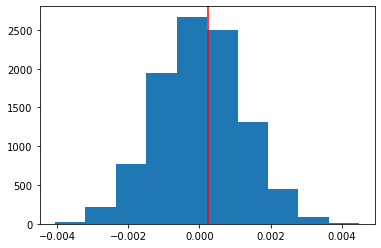

In [27]:
#plot p_diffs histogram
plt.hist(p_diffs)
plt.axvline(x = obs_diff, color = 'red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
act_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()

(p_diffs > act_diff).mean()


0.9104

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**P value is the probability of obtaining an effect at least as extreme as the one in your sample data, assuming the truth of the null hypothesis.<br>Highe P-Value indicate our data most likely assuming the true null. <br><br>The p-value we get is very high and close to 1. We will reject the alternative hypothise and conclude that there is no statistcal significance that the new treatment page leads to more conversion.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = len(df2.query('landing_page == "old_page" and converted==1'))
convert_new = len(df2.query('landing_page == "new_page" and converted==1'))
n_old = len(df2.query('landing_page == "old_page" '))
n_new = len(df2.query('landing_page == "new_page" '))


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative ='larger')
stat, pval

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score and p-value we computed based on ststsmodels agree with the findings in parts j and k. There is no statistcal significance that the new treatment page leads to more conversion.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We should perform logistic regression since the categorical variable only two possible outcome, whether conversion(1) or no conversion(0).**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1
#create dummy variable and assign treatment = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [32]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
results = log_mod.fit()
results.summary2()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-08-08 20:25 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

**The p-value associated with ab_page is 0.1899. The p-value different from Part II because two-tail test is performed with regression model while one-tail teset is performed at Part II.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**The most important advantage of Multivariate regression is it helps us to understand the relationships among variables present in the dataset. Adding additional terms into regression model will make our model overfit. Overfitting a model is a condition where a statistical model begins to describe the random error in the data rather than the relationships between variables. This problem occurs when the model is too complex.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion? Provide the statistical output as well as a written response to answer this question.

In [34]:
country = pd.read_csv('countries.csv')
#merge dataframe
df3 = pd.merge(df2, country, how='inner', on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [35]:
#create dummy variables
df3[['ab_page','old_page']] = pd.get_dummies(df3['landing_page'])
df3[['US','UK', 'CA']] = pd.get_dummies(df3['country'])
df3.drop('CA',axis=1)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,old_page,US,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
290579,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,US,1,0,0
290580,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,US,1,0,0
290581,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,US,1,0,0
290582,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0,US,1,0,0


In [36]:
logit_1 = sm.Logit(df3['converted'], df3[['intercept','ab_page', 'US','UK']]).fit()
logit_1.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-08-08 20:25 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

**$p_{old}$ :Different country and landing page had no impact on conversion rate.**<br>
**$p_{new}$ :Different country and landing page had impact on conversion rate.**<br>
Type I error rate of 5%<br><br>Based on the P-value we get from the regression model, all P-value are greater than 0.05 and we failed to reject null hypothesis. We can conclude that different country and landing page had no impact on conversion

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [37]:
df3['UK_ab_page'] = df3['UK'] * df3['ab_page']
df3['US_ab_page'] = df3['US'] * df3['ab_page']

In [38]:
logit_2 = sm.Logit(df3['converted'], df3[['intercept','ab_page', 'US','UK','UK_ab_page','US_ab_page']]).fit()
logit_2.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-08-08 20:25 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
US           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
US_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

**$p_{old}$ :Interaction between country and landing page had no impact on conversion rate.**<br>
**$p_{new}$ :Interaction between country and landing page had impact on conversion rate.**<br>
Type I error rate of 5%<br><br>Based on the P-value we get from the regression model, all P-value are greater than 0.05 and we failed to reject null hypothesis. We can conclude that interaction between country and landing page had no impact on conversion

## **Conclusion: After we take looked at the**<br>
1. individual factors of country and page on conversion<br>
2. interaction between page and country to see if there significant effects on conversion. <br>
Company should keep the old page as there is no significance evidence that new pages lead to new conversion after we consider all the factors.